In [1]:
import pandas as pd
import glob
from math import sqrt
import warnings
import numpy as np
import pandas as pd
import xgboost as xg
import numpy as np
import math
import scipy.stats as stats
from math import sqrt
from datetime import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
path = 'T:\eMerging Channels\Power BI\eMerging Aggregate Dashboard\Data\Costco\Weekly Data Instore and EComm/'
all_files = glob.glob(path+"/*.csv")
all_files

['T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-02-20.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-02-27.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-03-06.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-03-13.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-03-20.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco ECOM Sales - 2022-03-27.csv',
 'T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Weekly Data Instore and EComm\\Costco E

In [3]:
lis = []
for filename in all_files:
     df = pd.read_csv(filename,index_col=None,header =0,sep = ',',skiprows = [0,1])
     lis.append(df)
     #print("1")
df1 =pd.concat(lis,axis=0,ignore_index =True) 


In [4]:
df2 = pd.read_csv("T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Historical Data EComm\\Costco ECOM Sales.csv")
df3 = pd.read_csv("T:\\eMerging Channels\\Power BI\\eMerging Aggregate Dashboard\\Data\\Costco\\Historical Data Instore\\Costco IN-STORE Sales.csv")

In [5]:
import pandas as pd
b = pd.read_excel(r"W:\Client Folders\Tempur-Sealy\2022\2022 10 Analyst Research\CostcoSKUtoItemNumber.xlsx")
c = pd.read_excel(r"W:\Client Folders\Tempur-Sealy\2022\2022 10 Analyst Research\ProductMaster20220930.xlsx")
#d = pd.read_excel(r"T:\eMerging Channels\Power BI\eMerging Aggregate Dashboard\Data\Costco\Product Catalog\Costco - Product Master – Item.xlsx")
#e = pd.read_excel(r"T:\eMerging Channels\Power BI\eMerging Aggregate Dashboard\Data\Costco\Product Catalog\Costco - Product Master - UPC.xlsx")

In [6]:
df4 = pd.concat([df2, df3])
df5 = pd.concat([df1,df4])
display(df5.shape)
#df5.head()

(436775, 13)

In [7]:
df5 = df5[['Item','Time','Gross Units']]
df5[['Item','Time']] = df5[['Item','Time']].astype(str)
#df5.head()

In [8]:
import re
def get_num(x):
    num = re.findall(r'\d+', x)         
    num = [int(i) for i in num if len(i) == 9]
    if len(num) > 0:
        return num[0]
    else:
        return 1
    
# Get the itemnumber from the item name    
df5['Item_Number'] = df5['Item'].apply(lambda x: get_num(x))   
#df5.head()

In [9]:
import datetime
from datetime import date
import re
def get_date(x):
    match = re.search(r'\d{2}-\d{2}-\d{4}', x)         
    date = datetime.datetime.strptime(match.group(), '%m-%d-%Y').date()
    if (date) :
        return date
    else:
        return 1
    
# Get the itemnumber from the item name    
df5['Time_Date'] = df5['Time'].apply(lambda x: get_date(x))   


In [10]:
d = pd.read_excel(r"T:\eMerging Channels\Power BI\eMerging Aggregate Dashboard\Data\Costco\Product Catalog\Costco - Product Master - Item.xlsx",skiprows=7)
display(d.shape)

(1107, 15)

In [11]:
b.head()

,SKU,ItemNumber
0,729898.0,10255150
1,1312333.0,F01-00586-ST6
2,1261888.0,F01-00614-ST0
3,1493539.0,F01-00747-ST0
4,622961.0,198-0A


In [74]:
# Drop null values
b.dropna(inplace=True)
# convert join key into string to map more records
df5['Item_Number'] = df5['Item_Number'].apply(lambda x: str(x).strip())
b['SKU'] = b['SKU'].apply(lambda x: str(int(x)).strip())
c['Item Number'] = c['Item Number'].apply(lambda x: str(x).strip())
d['Item_Number  [ ByItem_Item ]'] = d['Item_Number  [ ByItem_Item ]'].apply(lambda x: str(x).strip())


# Merge sales data with master data
item_merge = pd.merge(df5, b, how='inner', left_on='Item_Number', right_on='SKU')
item_merge['ItemNumber'] = item_merge['ItemNumber'].apply(lambda x: str(x).strip())



merge_prod_master_item = pd.merge(item_merge, c, how='inner', left_on='ItemNumber', right_on='Item Number')

merge_3 = d.merge(merge_prod_master_item, left_on='Item_Number  [ ByItem_Item ]',right_on='SKU') #(382693, 25)

merge_3['yyyy'] = pd.to_datetime(merge_3['Time_Date']).dt.year
merge_3['mm'] = pd.to_datetime(merge_3['Time_Date']).dt.month

merge_3.shape

(384659, 42)

In [75]:
merge_4 = merge_3.copy()
merge_4 = merge_4.groupby(['Item_Number', 'Dept_Code  [ ByItem_Item ]',
       'Dept_Name  [ ByItem_Item ]', 'Item_Number  [ ByItem_Item ]','SubCat_Name  [ ByItem_Item ]',
'Manufacturer','Gross Units','Time_Date']).agg({'mm':'sum', 'Cat_Name  [ ByItem_Item ]': 'sum','yyyy':'sum'}).reset_index()
merge_4.sort_values(by=['Item_Number','Time_Date'], ascending=True,inplace=True)
#merge_4.head()

In [76]:
# Adding Tentpole
tentpole_calender=pd.read_excel("C:/Users/ArjunDas.H/Downloads/holidayCalendar.xlsx")
merge_4['Time_Date'] = pd.to_datetime(merge_4['Time_Date'])
merge_4 = pd.merge(merge_4, tentpole_calender, how="left", left_on=("Time_Date"),right_on = 'Holiday Date')

In [77]:
# Creating Holiday Column

merge_4["Holiday"] = np.where((merge_4['Holiday Name'].isnull()), 0, 1)

# Creating Dummy variable for each tentpole day

df_tp = pd.get_dummies(data=merge_4[['Holiday Name']])
df_tp.fillna(0, inplace=True)
merge_4 = pd.concat([merge_4,df_tp], axis=1)
merge_4 = merge_4.drop(['Holiday Name'],axis=1)

In [78]:
#Lag values
#merge_4['Gross Units']= merge_4['Gross Units'].astype('int')

merge_4['Prev_week'] =  merge_4.groupby('Item_Number')['Gross Units'].shift()
merge_4['Prev_week2'] =  merge_4.groupby('Item_Number')['Gross Units'].shift(2)
merge_4['Prev_week3'] =  merge_4.groupby('Item_Number')['Gross Units'].shift(3)

merge_4.dropna(subset=['Prev_week','Prev_week2','Prev_week3'],inplace=True)

#merge_4.head()

In [79]:
merge_4['Time_Date'][(merge_4["Holiday Name_New Year's Day"]==1)].value_counts()

2022-01-01    204
2021-01-01    149
2020-01-01    140
Name: Time_Date, dtype: int64

In [80]:
# Data For Forecasting
merge_4_forecast = merge_4[(merge_4['yyyy'] == 2022) & (merge_4['mm'] > 9)].reset_index(drop = True)
display(merge_4_forecast.shape)

(4500, 29)

In [81]:
# Data For Training
merge_4 = merge_4.drop(merge_4[(merge_4['yyyy'] == 2022)&(merge_4['mm'] > 9)].index)
merge_4.shape

(343345, 29)

In [82]:
merge_4['Gross Units'] = merge_4['Gross Units'].apply(lambda x: int(str(x).replace(",","")))
merge_4['Prev_week'] = merge_4['Prev_week'].apply(lambda x: int(str(x).replace(",","")))
merge_4['Prev_week2'] = merge_4['Prev_week2'].apply(lambda x: int(str(x).replace(",","")))
merge_4['Prev_week3'] = merge_4['Prev_week3'].apply(lambda x: int(str(x).replace(",","")))

merge_4_forecast['Gross Units'] = merge_4_forecast['Gross Units'].apply(lambda x: int(str(x).replace(",","")))
merge_4_forecast['Prev_week'] = merge_4_forecast['Prev_week'].apply(lambda x: int(str(x).replace(",","")))
merge_4_forecast['Prev_week2'] = merge_4_forecast['Prev_week2'].apply(lambda x: int(str(x).replace(",","")))
merge_4_forecast['Prev_week3'] = merge_4_forecast['Prev_week3'].apply(lambda x: int(str(x).replace(",","")))


In [83]:
XGBR = xg.XGBRegressor(n_estimators=100, objectvie='reg:squarederror', booster='gbtree',random_state=42, learning_rate=0.05)

train_df = pd.DataFrame()
forecast = pd.DataFrame()
evaluation_dict = {"Product line":[], "R-Square":[], "RMSE":[], "MAE":[]}
models = dict()

prod_line_list = list(merge_4['Dept_Name  [ ByItem_Item ]'].unique())

remove_cols = ['Item_Number', 'Dept_Code  [ ByItem_Item ]','Dept_Name  [ ByItem_Item ]','Holiday Date',
        'Item_Number  [ ByItem_Item ]','Gross Units','SubCat_Name  [ ByItem_Item ]', 'Manufacturer', 'Time_Date', 'Cat_Name  [ ByItem_Item ]']
for prod in prod_line_list:
    temp = merge_4[merge_4['Dept_Name  [ ByItem_Item ]'] == prod]
    temp2=merge_4[merge_4['Dept_Name  [ ByItem_Item ]']==prod]

    
    X = temp.drop(remove_cols,axis=1)

    y = temp['Gross Units']

    mod = XGBR.fit(X,y)
    models[prod] = mod
    train_prediction = np.round(mod.predict(X),1)
    #train_df = pd.concat([train_df,temp], axis=0, ignore_index=True)
    
    
    # prediction

    tempforecast2022 = merge_4_forecast[merge_4_forecast['Dept_Name  [ ByItem_Item ]'] == prod].reset_index(drop = True)
    test_x = tempforecast2022[list(X.columns)]
    #display(test_x.shape)
    
    pl =mod.predict(test_x)
    #display(pl)
    tempforecast2022['Predicted_Quantity'] = np.round(mod.predict(test_x),1)

    tempforecast2022.drop(remove_cols,axis=1, inplace=True)
    
    
    X['ProductLine'] = prod
    #X['ItemID'] = temp2['ItemID']
    X["Actual"] = y
    X['Prediction'] = train_prediction
    
    train_df = pd.concat([train_df,X], axis=0)
    
    forecast = pd.concat([forecast,tempforecast2022], axis=0)
    
    

# Evaluation
    evaluation_dict["Product line"].append(prod)
    #evaluation_dict["R-Square"].append(mod.rsquared)
    evaluation_dict["RMSE"].append(round(sqrt(mean_squared_error(X["Actual"], X['Prediction'])),2))
    evaluation_dict["MAE"].append(round(mean_absolute_error(X["Actual"], X['Prediction']),2))
    
#metric_df = pd.DataFrame(evaluation_dict)
forecast = forecast[forecast['Predicted_Quantity']>=0]

[17:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [84]:
# Model Building


train_df = pd.DataFrame()
evaluation_dict = {"Product line":[], "R-Square":[], "RMSE":[], "MAE":[]}
models = dict()

#price_zone_list = list(data['PriceZone'].unique())
prod_line_list = list(merge_4['Dept_Name  [ ByItem_Item ]'].unique())

remove_cols = ['Item_Number', 'Dept_Code  [ ByItem_Item ]','Dept_Name  [ ByItem_Item ]','Holiday Date',
        'Item_Number  [ ByItem_Item ]','Gross Units','SubCat_Name  [ ByItem_Item ]', 'Manufacturer', 'Time_Date', 'Cat_Name  [ ByItem_Item ]']

  
for prod in prod_line_list:
    temp = merge_4[merge_4['Dept_Name  [ ByItem_Item ]'] == prod]
    p = np.percentile(temp['Gross Units'], 99.99)
    temp = temp[temp['Gross Units']<=p]

    X = temp.drop(remove_cols,axis=1)
    y = temp['Gross Units']

    XGBR = xg.XGBRegressor(n_estimators=70, objectvie='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.4)
    mod = XGBR.fit(X,y)
    models[prod] = mod
    temp['Predicted_Quantity'] = np.round(mod.predict(X),1) 
    train_df = pd.concat([train_df,temp], axis=0, ignore_index=True)

# Evaluation
    evaluation_dict["Product line"].append(prod)
    evaluation_dict["R-Square"].append(round(sqrt(r2_score(temp['Gross Units'], temp['Predicted_Quantity'])),2))
    evaluation_dict["RMSE"].append(round(sqrt(mean_squared_error(temp['Gross Units'], temp['Predicted_Quantity'])),2))
    evaluation_dict["MAE"].append(round(mean_absolute_error(temp['Gross Units'], temp['Predicted_Quantity']),2))

metric_df = pd.DataFrame(evaluation_dict)

[17:09:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [85]:
test_df = merge_4_forecast.copy()
final_df = pd.DataFrame()
ivs = list(X.columns)
for mod in models.keys():
    tmp = test_df[test_df['Dept_Name  [ ByItem_Item ]'] == mod]
    #display(tmp.head())
    p = np.percentile(tmp['Gross Units'], 99.99)
    tmp = tmp[tmp['Gross Units']<=p]
    #display(models[mod].predict(tmp[ivs]))
    tmp['Predicted_Quantity'] = models[mod].predict(tmp[ivs])

final_df = pd.concat([final_df,tmp], axis=0, ignore_index=True)

In [86]:
final_df.columns

Index(['Item_Number', 'Dept_Code  [ ByItem_Item ]',
       'Dept_Name  [ ByItem_Item ]', 'Item_Number  [ ByItem_Item ]',
       'SubCat_Name  [ ByItem_Item ]', 'Manufacturer', 'Gross Units',
       'Time_Date', 'mm', 'Cat_Name  [ ByItem_Item ]', 'yyyy', 'Holiday Date',
       'Holiday', 'Holiday Name_(in lieu of Juneteenth)',
       'Holiday Name_Black Friday', 'Holiday Name_Christmas Day',
       'Holiday Name_Columbus Day', 'Holiday Name_Independence Day',
       'Holiday Name_Juneteenth', 'Holiday Name_Labor Day',
       'Holiday Name_Martin Luther King, Jr.', 'Holiday Name_Memorial Day',
       'Holiday Name_New Year's Day', 'Holiday Name_Presidents' Day',
       'Holiday Name_Thanksgiving Day', 'Holiday Name_Veterans Day',
       'Prev_week', 'Prev_week2', 'Prev_week3', 'Predicted_Quantity'],
      dtype='object')

<AxesSubplot:>

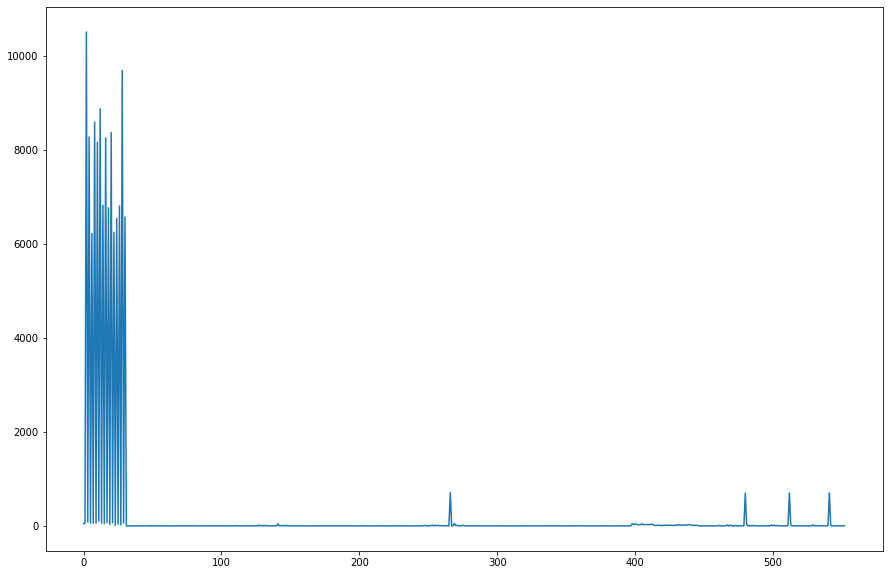

In [87]:
final_df['Predicted_Quantity'].plot()

<AxesSubplot:xlabel='Gross Units', ylabel='Predicted_Quantity'>

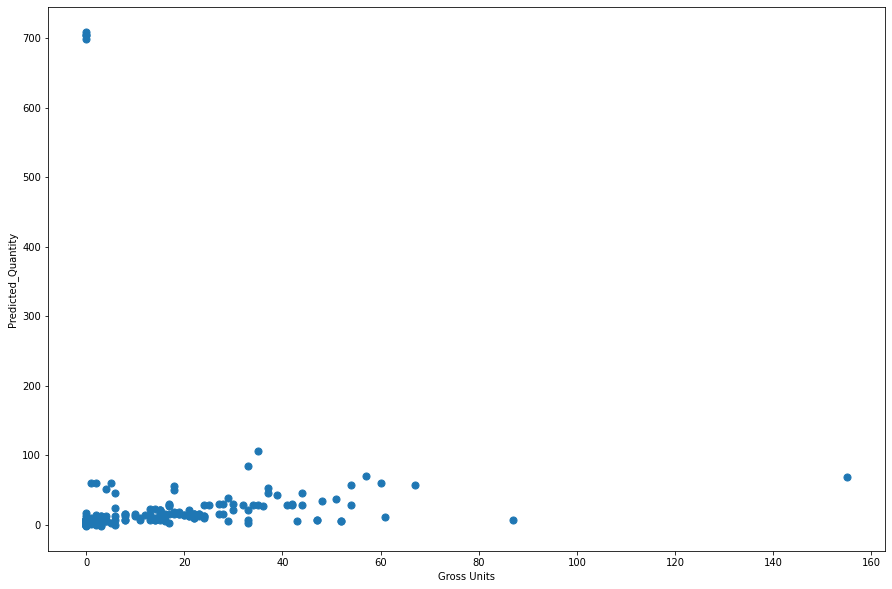

In [88]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
new_df = final_df[final_df['Predicted_Quantity']<1000]
new_df.plot.scatter(x = 'Gross Units', y = 'Predicted_Quantity', s = 50)

In [72]:
final_df.columns # Day after promotion -

Index([], dtype='object')

## Clustering

In [55]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure,homogeneity_score

In [89]:
df_new=merge_4.drop(remove_cols ,axis=1) 
df_new['Gross Units'] = merge_4['Gross Units']
test_n = merge_4_forecast.drop(remove_cols ,axis=1) 
test_n['Gross Units'] = merge_4_forecast['Gross Units']
df_new.head()

,mm,yyyy,Holiday,Holiday Name_(in lieu of Juneteenth),Holiday Name_Black Friday,Holiday Name_Christmas Day,Holiday Name_Columbus Day,Holiday Name_Independence Day,Holiday Name_Juneteenth,Holiday Name_Labor Day,"Holiday Name_Martin Luther King, Jr.",Holiday Name_Memorial Day,Holiday Name_New Year's Day,Holiday Name_Presidents' Day,Holiday Name_Thanksgiving Day,Holiday Name_Veterans Day,Prev_week,Prev_week2,Prev_week3,Gross Units
3,1,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_new.columns

Index(['mm', 'yyyy', 'Holiday', 'Holiday Name_(in lieu of Juneteenth)',
       'Holiday Name_Black Friday', 'Holiday Name_Christmas Day',
       'Holiday Name_Columbus Day', 'Holiday Name_Independence Day',
       'Holiday Name_Juneteenth', 'Holiday Name_Labor Day',
       'Holiday Name_Martin Luther King, Jr.', 'Holiday Name_Memorial Day',
       'Holiday Name_New Year's Day', 'Holiday Name_Presidents' Day',
       'Holiday Name_Thanksgiving Day', 'Holiday Name_Veterans Day',
       'Prev_week', 'Prev_week2', 'Prev_week3', 'Gross Units'],
      dtype='object')

In [58]:
kmeans = KMeans(3)
kmeans.fit(df_new)
identified_clusters = kmeans.fit_predict(df_new)
identified_clusters

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_new)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05,3.433450e+05
mean,1.304595e-16,3.311155e-17,2.417143e-17,-1.283072e-18,-1.663855e-17,4.490753e-18,2.160528e-17,-2.400587e-18,2.021874e-17,1.512784e-17,6.208415e-18,-1.007833e-17,-1.974276e-17,-1.467255e-17,4.263112e-18,-9.705822e-18,5.463405e-18,1.258239e-17,-5.132290e-18,-1.109237e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.366635e+00,-3.430846e-01,-1.679398e-01,-2.617081e-02,-4.444855e-02,-4.331588e-02,-4.946378e-02,-5.103662e-02,-3.706322e-02,-5.126558e-02,-5.169216e-02,-5.219950e-02,-3.792016e-02,-5.399232e-02,-4.273838e-02,-4.823568e-02,-1.130110e-01,-1.130220e-01,-1.134171e-01,-1.124991e-01
25%,-6.795292e-01,-3.414586e-01,-1.679398e-01,-2.617081e-02,-4.444855e-02,-4.331588e-02,-4.946378e-02,-5.103662e-02,-3.706322e-02,-5.126558e-02,-5.169216e-02,-5.219950e-02,-3.792016e-02,-5.399232e-02,-4.273838e-02,-4.823568e-02,-9.003961e-02,-9.005081e-02,-9.032966e-02,-8.965666e-02
50%,7.576585e-03,-3.382067e-01,-1.679398e-01,-2.617081e-02,-4.444855e-02,-4.331588e-02,-4.946378e-02,-5.103662e-02,-3.706322e-02,-5.126558e-02,-5.169216e-02,-5.219950e-02,-3.792016e-02,-5.399232e-02,-4.273838e-02,-4.823568e-02,-9.003961e-02,-9.005081e-02,-9.032966e-02,-8.965666e-02
75%,6.946824e-01,-3.365808e-01,-1.679398e-01,-2.617081e-02,-4.444855e-02,-4.331588e-02,-4.946378e-02,-5.103662e-02,-3.706322e-02,-5.126558e-02,-5.169216e-02,-5.219950e-02,-3.792016e-02,-5.399232e-02,-4.273838e-02,-4.823568e-02,-8.429675e-02,-8.430802e-02,-8.455780e-02,-8.394605e-02
max,3.901176e+00,2.951063e+00,5.954515e+00,3.821050e+01,2.249792e+01,2.308622e+01,2.021681e+01,1.959377e+01,2.698092e+01,1.950627e+01,1.934529e+01,1.915727e+01,2.637120e+01,1.852115e+01,2.339817e+01,2.073154e+01,1.348556e+02,1.348540e+02,1.355370e+02,1.340982e+02


In [90]:
kmeans = KMeans(3)
kmeans.fit(test_n)
identified_clusters = kmeans.fit_predict(test_n)
identified_clusters

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_n)

# statistics of scaled data
pd.DataFrame(test_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,4500.0,4500.0,4.500000e+03,4500.0,4500.0,4500.0,4.500000e+03,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03
mean,0.0,0.0,-3.730349e-17,0.0,0.0,0.0,-3.730349e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.315935e-18,6.315935e-18,-3.157968e-18,6.315935e-18
std,0.0,0.0,1.000111e+00,0.0,0.0,0.0,1.000111e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00
min,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.551826e-02,-6.574054e-02,-6.568212e-02,-6.574605e-02
25%,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.551826e-02,-6.574054e-02,-6.568212e-02,-6.574605e-02
50%,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.551826e-02,-6.574054e-02,-6.568212e-02,-6.574605e-02
75%,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,-2.610028e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.551826e-02,-6.574054e-02,-6.568212e-02,-6.574605e-02
max,0.0,0.0,3.831376e+00,0.0,0.0,0.0,3.831376e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.262593e+01,2.262589e+01,2.245274e+01,2.297926e+01


In [59]:
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=2)

Text(0, 0.5, 'Inertia')

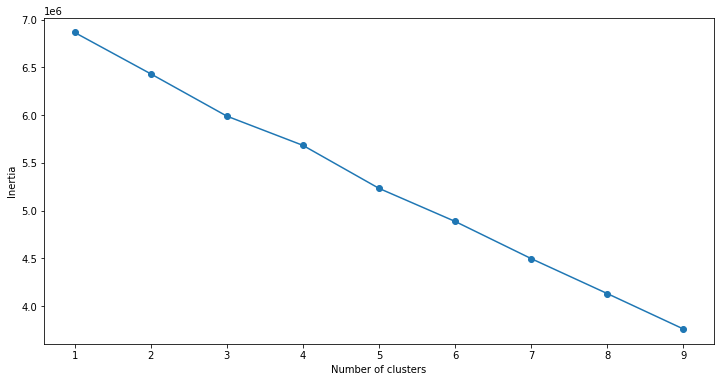

In [60]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [61]:
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [95]:
frame = pd.DataFrame(data_scaled)
frame_test = pd.DataFrame(test_scaled)
frame.columns = ['mm', 'yyyy', 'Holiday', 'Holiday Name_(in lieu of Juneteenth)',
       'Holiday Name_Black Friday', 'Holiday Name_Christmas Day',
       'Holiday Name_Columbus Day', 'Holiday Name_Independence Day',
       'Holiday Name_Juneteenth', 'Holiday Name_Labor Day',
       'Holiday Name_Martin Luther King, Jr.', 'Holiday Name_Memorial Day',
       "Holiday Name_New Year's Day", "Holiday Name_Presidents' Day",
       'Holiday Name_Thanksgiving Day', 'Holiday Name_Veterans Day',
       'Prev_week', 'Prev_week2', 'Prev_week3', 'Gross Units']
frame['cluster'] = pred
frame['cluster'].value_counts()

1    303485
0     38130
3       933
2       797
Name: cluster, dtype: int64

In [96]:
frame.head()

,mm,yyyy,Holiday,Holiday Name_(in lieu of Juneteenth),Holiday Name_Black Friday,Holiday Name_Christmas Day,Holiday Name_Columbus Day,Holiday Name_Independence Day,Holiday Name_Juneteenth,Holiday Name_Labor Day,...,Holiday Name_Memorial Day,Holiday Name_New Year's Day,Holiday Name_Presidents' Day,Holiday Name_Thanksgiving Day,Holiday Name_Veterans Day,Prev_week,Prev_week2,Prev_week3,Gross Units,cluster
0,-1.366635,-0.343085,-0.16794,-0.026171,-0.044449,-0.043316,-0.049464,-0.051037,-0.037063,-0.051266,...,-0.052199,-0.03792,-0.053992,-0.042738,-0.048236,-0.09004,-0.090051,-0.09033,-0.089657,1
1,-1.366635,-0.343085,-0.16794,-0.026171,-0.044449,-0.043316,-0.049464,-0.051037,-0.037063,-0.051266,...,-0.052199,-0.03792,-0.053992,-0.042738,-0.048236,-0.09004,-0.090051,-0.09033,-0.089657,1
2,-1.366635,-0.343085,-0.16794,-0.026171,-0.044449,-0.043316,-0.049464,-0.051037,-0.037063,-0.051266,...,-0.052199,-0.03792,-0.053992,-0.042738,-0.048236,-0.09004,-0.090051,-0.09033,-0.089657,1
3,-1.366635,-0.343085,-0.16794,-0.026171,-0.044449,-0.043316,-0.049464,-0.051037,-0.037063,-0.051266,...,-0.052199,-0.03792,-0.053992,-0.042738,-0.048236,-0.09004,-0.090051,-0.09033,-0.089657,1
4,-1.366635,-0.343085,-0.16794,-0.026171,-0.044449,-0.043316,-0.049464,-0.051037,-0.037063,-0.051266,...,-0.052199,-0.03792,-0.053992,-0.042738,-0.048236,-0.09004,-0.090051,-0.09033,-0.089657,1


In [97]:
#Age of the sku -Giving zeros in months where min date is not jan.

In [98]:
XGBR = xg.XGBRegressor(n_estimators=100, objectvie='reg:squarederror', booster='gbtree',random_state=42, learning_rate=0.05)

train_df = pd.DataFrame()
evaluation_dict = {"Product line":[], "R-Square":[], "RMSE":[], "MAE":[]}
models = dict()

prod_line_list = list(frame['cluster'].unique())

remove_cols = ['Item_Number', 'Dept_Code  [ ByItem_Item ]','Dept_Name  [ ByItem_Item ]',
        'Item_Number  [ ByItem_Item ]','Gross Units','SubCat_Name  [ ByItem_Item ]', 'Manufacturer', 'Time_Date', 'Cat_Name  [ ByItem_Item ]']
for prod in prod_line_list:
    temp = frame[frame['cluster'] == prod]
    
    X = temp

    y = temp['Gross Units']

    mod = XGBR.fit(X,y)
    models[prod] = mod
    temp['Predicted_Quantity'] = np.round(mod.predict(X),1)
    train_df = pd.concat([train_df,temp], axis=0, ignore_index=True)

# Evaluation
    #evaluation_dict["Product line"].append(prod)
    #evaluation_dict["R-Square"].append(round(sqrt(r2_score(temp['Gross Units'], temp['Predicted_Quantity'])),2))
    #evaluation_dict["RMSE"].append(round(sqrt(mean_squared_error(temp['Gross Units'], temp['Predicted_Quantity'])),2))
    #evaluation_dict["MAE"].append(round(mean_absolute_error(temp['Gross Units'], temp['Predicted_Quantity']),2))

metric_df = pd.DataFrame(evaluation_dict)

[17:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\ArjunDas.H\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[17:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:31:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could b

In [ ]:
test